In [97]:
import pandas as pd
from sklearn.decomposition import PCA
import seaborn

df = pd.read_csv("../Donnees/cleaned_data.csv")


<Axes: ylabel='Frequency'>

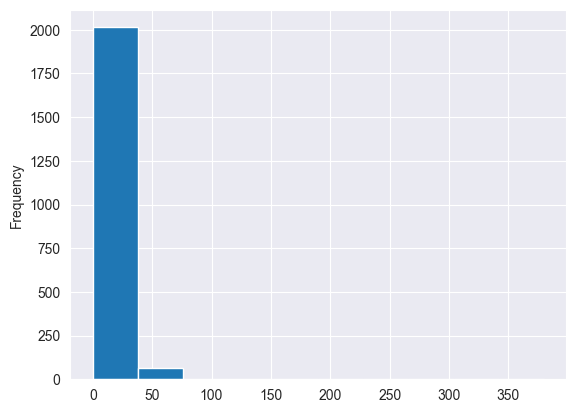

In [98]:
df["price"].plot.hist()

<Axes: >

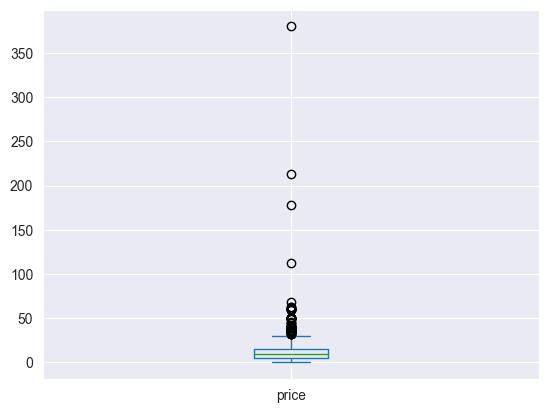

In [99]:
df["price"].plot.box()

In [100]:
number_columns = ["rating", "retirement", "time", "price", "review_count", "rating_value", "twenty_four_hours", "all_time"]
dfn = df[number_columns]

In [101]:
from sklearn.preprocessing import StandardScaler

dfn = pd.DataFrame(StandardScaler().fit_transform(dfn), columns=dfn.columns)

dfn

,rating,retirement,time,price,review_count,rating_value,twenty_four_hours,all_time
0,0.542965,0.075920,-0.085944,-0.499445,-0.161152,0.625050,-0.124379,-0.160264
1,-1.040334,2.498223,-0.026295,-0.174390,-0.188934,-0.854863,-0.123883,-0.214388
2,-3.098623,2.618479,-0.097860,-0.499445,-0.190759,-1.594819,-0.124875,-0.185575
3,-0.723674,0.178997,-0.082471,0.020643,-0.196689,-0.854863,-0.124875,-0.215949
4,-0.486179,-0.027157,-0.085195,-0.174390,-0.196168,0.625050,-0.121650,-0.214908
...,...,...,...,...,...,...,...,...
2075,-0.486179,4.113091,0.170355,-0.823850,-0.135607,-1.594819,-0.112471,0.105341
2076,-2.148644,-0.576899,-0.105146,-0.753892,-0.181223,-0.854863,-0.123635,-0.168165
2077,0.147140,0.196176,-0.078794,-0.117915,-0.190607,0.625050,-0.122643,-0.213110
2078,-0.327849,-0.250490,-0.043863,1.295368,-0.129785,-1.594819,-0.120162,-0.042743


In [102]:
from sklearn.ensemble import IsolationForest

forest = IsolationForest()
outliers = forest.fit_predict(dfn)



FileNotFoundError: [Errno 2] No such file or directory: 'plot.png'

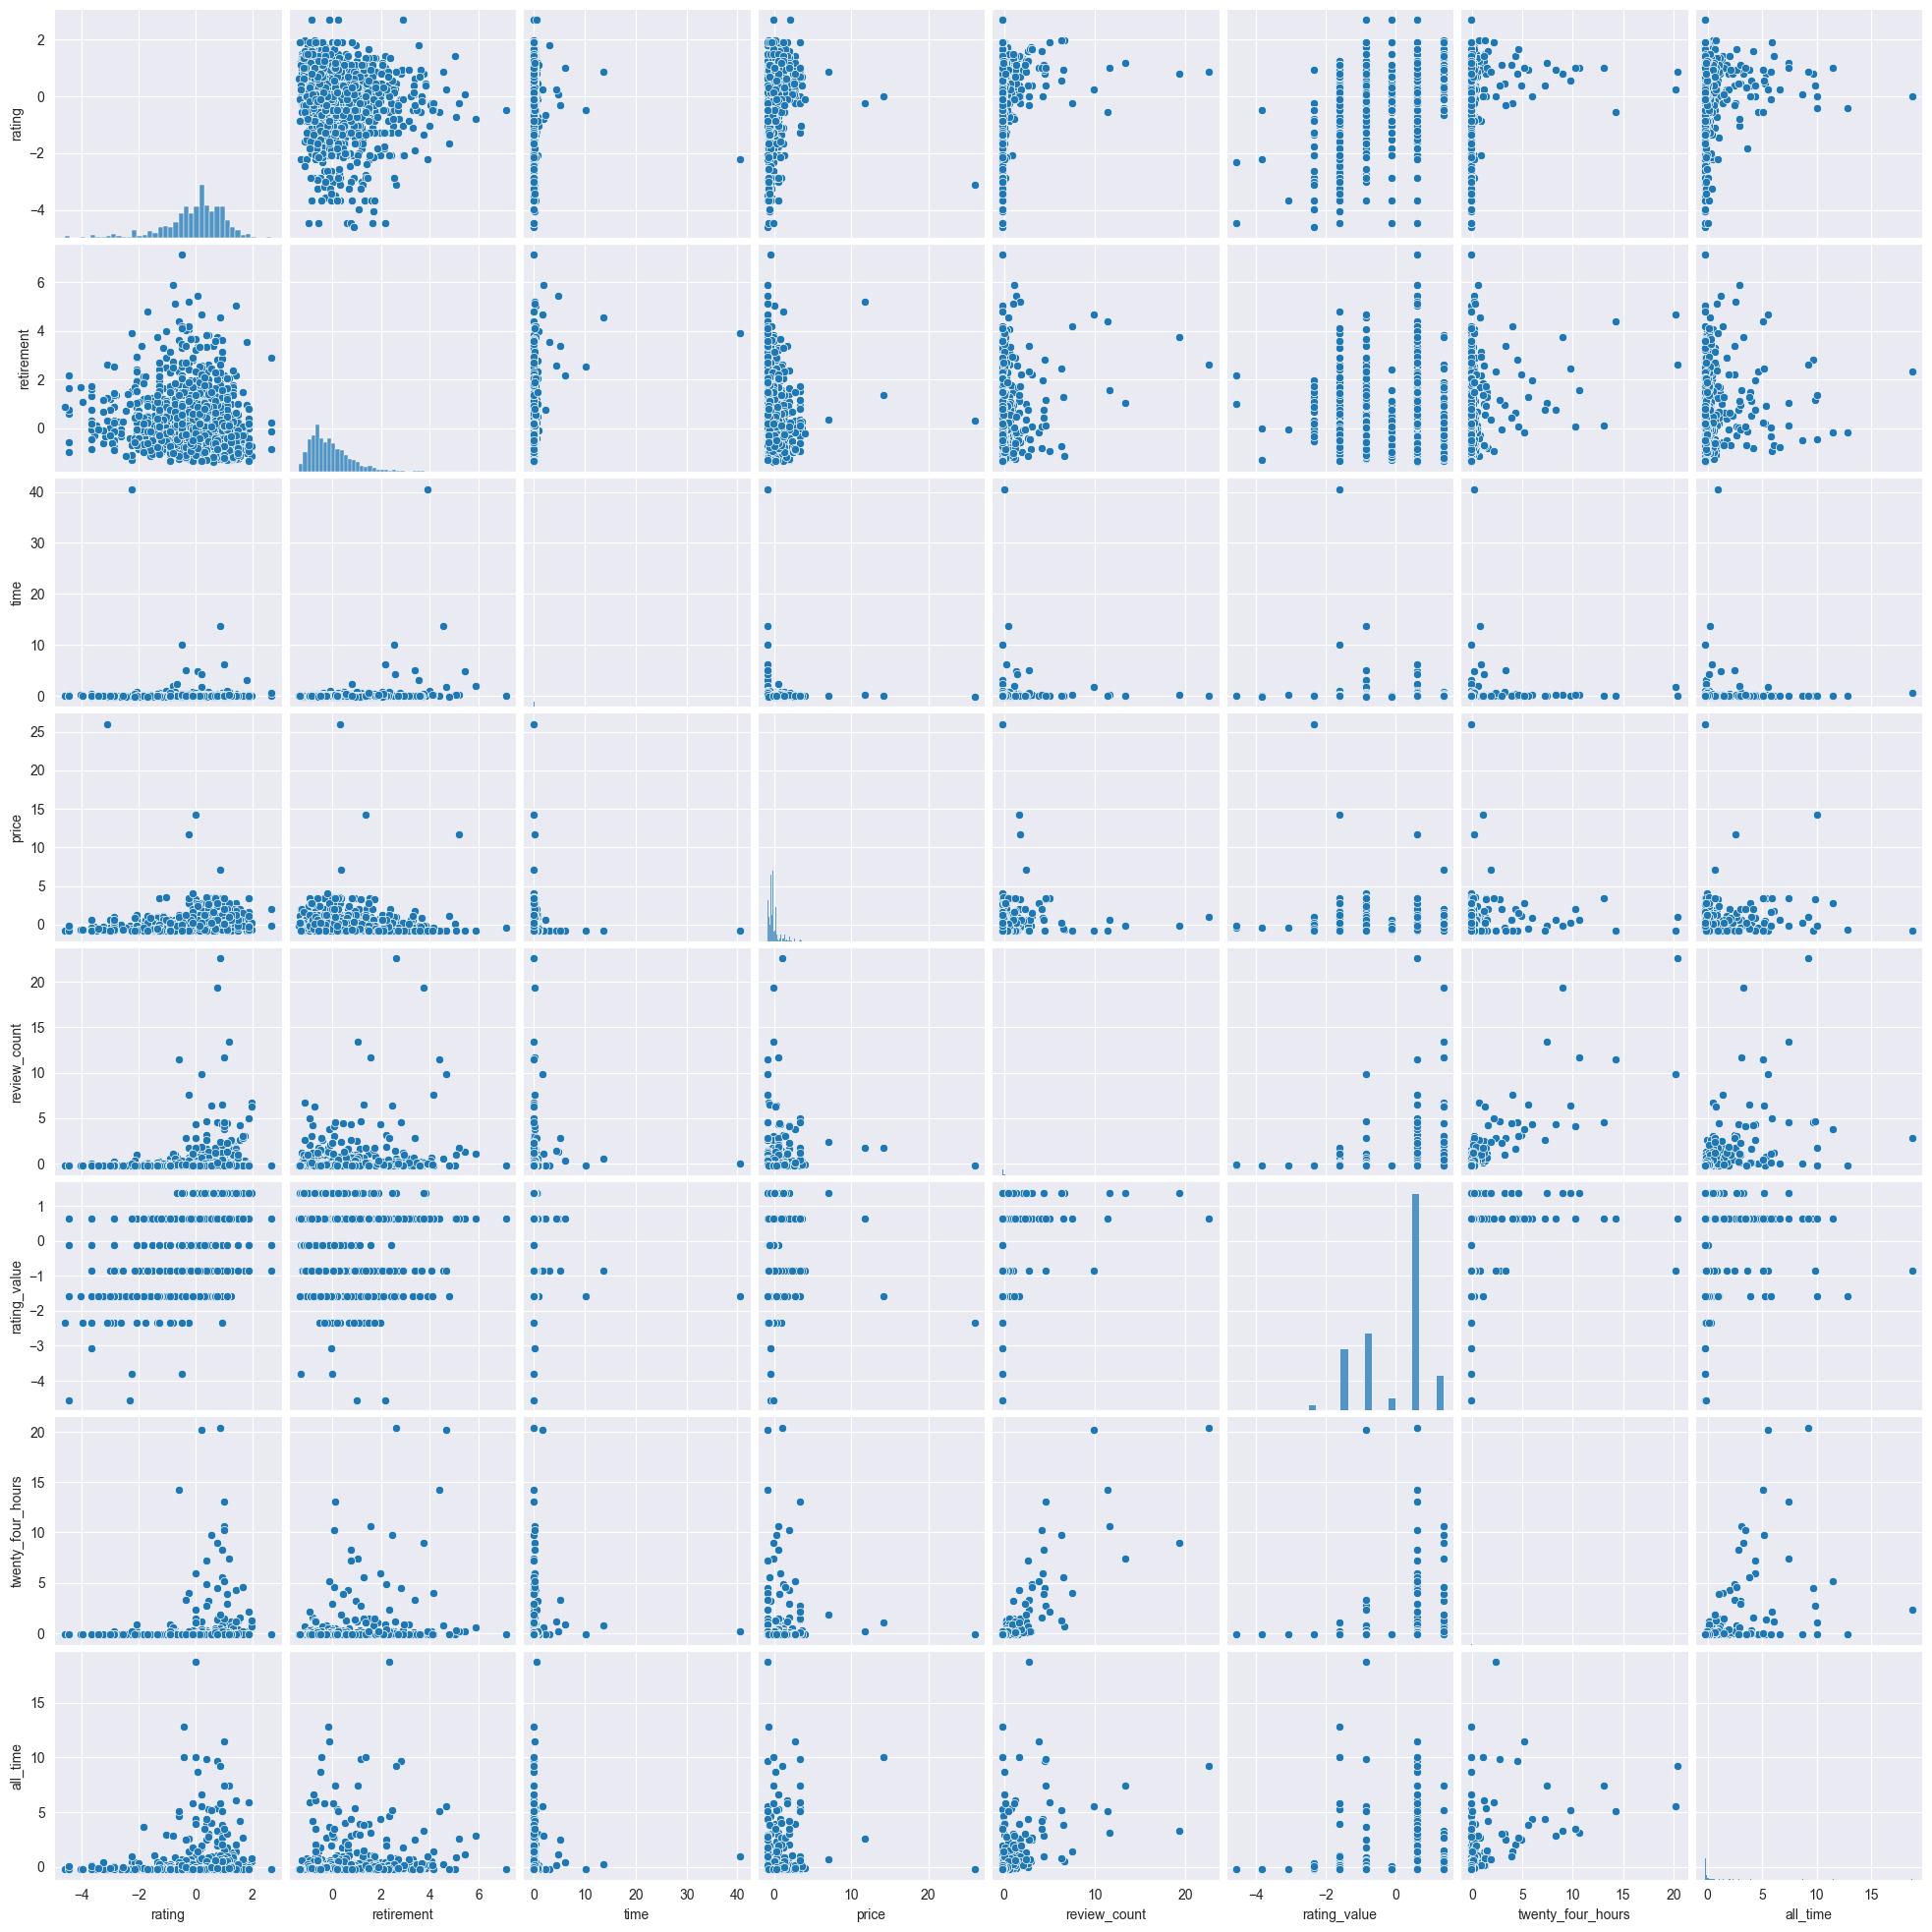

In [103]:
from matplotlib import pyplot as plt
import numpy as np

dnf = dfn.drop(index=np.where(outliers==-1)[0])

seaborn.pairplot(dfn)
plt.savefig("plot.png")


In [104]:
pca = PCA()

pca.fit(dfn)

PCA()

<Axes: title={'center': 'Proportion of variances'}, xlabel='Column number', ylabel="Ratio of the column's variance (%)">

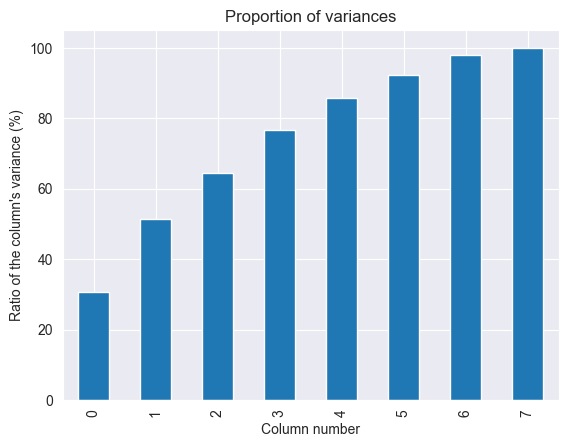

In [105]:
table = pd.DataFrame(np.concatenate((pca.explained_variance_, pca.explained_variance_ratio_, np.cumsum(pca.explained_variance_ratio_))).reshape((3, pca.n_components_)), index=["Explained variance", "Explained variance ratio", "Cumulated ratio"])


(100 * table.T["Cumulated ratio"]).plot.bar(title="Proportion of variances", xlabel="Column number", ylabel="Ratio of the column's variance (%)")

In [106]:


n = dfn.shape[0] # nb of individuals
p = dfn.shape[1] # nb of variables
print(n, '  ', p)
eigval = (n-1) / n * pca.explained_variance_ # eigen values
sqrt_eigval = np.sqrt(eigval)
corvar = np.zeros((p,p)) # empty matrix for coordinates
for k in range(p):
    corvar[:,k] = pca.components_[k,:] * sqrt_eigval[k]
# on modifie pour avoir un dataframe
coordvar = pd.DataFrame({'id': dfn.columns, 'COR_1': corvar[:,0], 'COR_2': corvar[:,1]})
coordvar

2080    8


,id,COR_1,COR_2
0,rating,0.210582,-0.806927
1,retirement,0.324326,0.554019
2,time,0.106317,0.264190
3,price,0.233183,-0.182463
4,review_count,0.905757,0.020901
5,rating_value,0.189491,-0.763431
6,twenty_four_hours,0.896271,0.081782
7,all_time,0.756895,0.075485


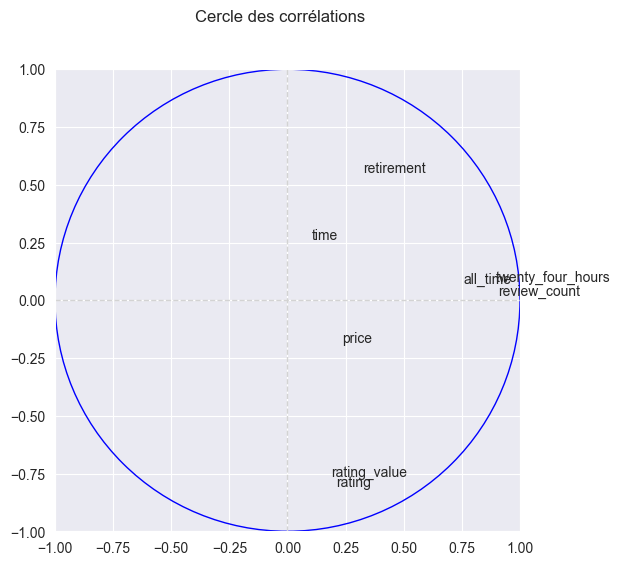

In [107]:
# Création d'une figure vide (avec des axes entre -1 et 1 + le titre)
fig, axes = plt.subplots(figsize = (6,6))
fig.suptitle("Cercle des corrélations")
axes.set_xlim(-1, 1)
axes.set_ylim(-1, 1)
# Ajout des axes
axes.axvline(x = 0, color = 'lightgray', linestyle = '--', linewidth = 1)
axes.axhline(y = 0, color = 'lightgray', linestyle = '--', linewidth = 1)
# Ajout des noms des variables
for j in range(p):
    axes.text(coordvar["COR_1"][j],coordvar["COR_2"][j], coordvar["id"][j])
# Ajout du cercle
plt.gca().add_artist(plt.Circle((0,0),1,color='blue',fill=False))

plt.show()

<BarContainer object of 8 artists>

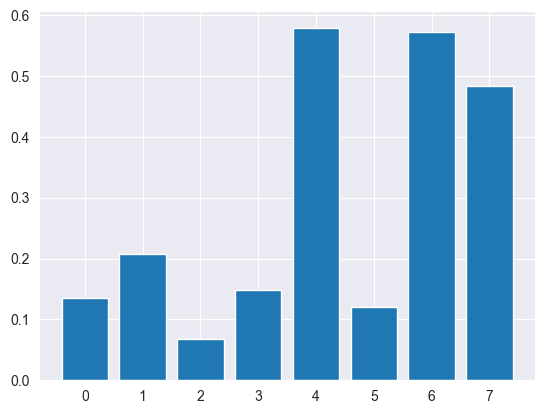

In [108]:
plt.bar(x=range(8),height=pca.components_[0])

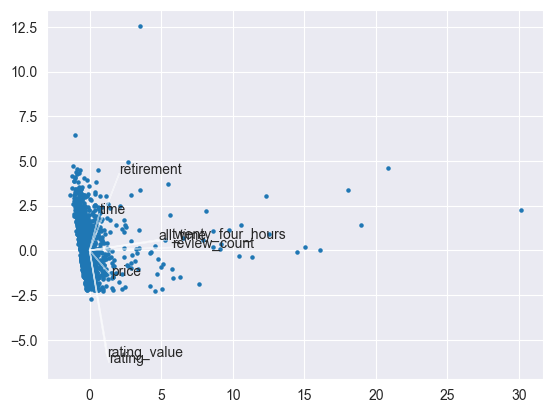

In [109]:
pca_data = pd.DataFrame(pca.transform(dfn)).truncate(after=4, axis=1)

plt.scatter(pca_data[0], pca_data[1], s=5)

for i in range(pca.components_.shape[1]):
    plt.arrow(0,0,pca.components_[0,i]*10,pca.components_[1,i]*10,alpha=0.5)
    plt.text(pca.components_[0,i]*10, pca.components_[1,i]*10, dfn.columns[i])

<Axes: xlabel='rating', ylabel='price'>

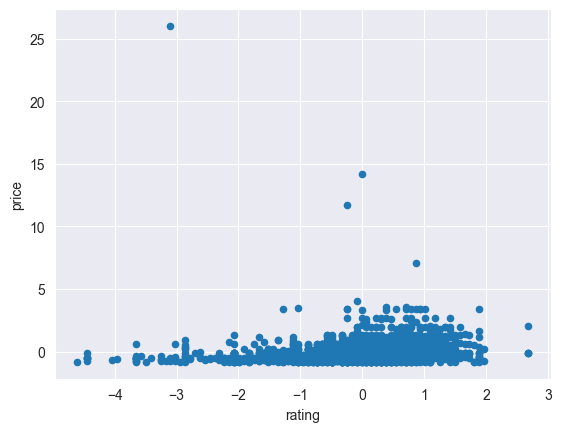

In [110]:
dfn.plot.scatter("rating", "price")